# Run inference on pre-trained model:

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
from tqdm.auto import tqdm
from torch.nn.functional import softmax

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from grace.base import GraphAttrs, Annotation

from grace.models.classifier import GCN
from grace.models.optimiser import optimise_graph
from grace.simulator.simulate_graph import random_graph

from grace.evaluation.visualisation import (
    plot_simple_graph,
    plot_connected_components,
)

from grace.evaluation.process import (
    generate_ground_truth_graph,
    update_graph_with_dummy_predictions,
    assume_annotations_from_dummy_predictions,
    # assume_dummy_predictions_from_annotations,
    # add_and_remove_random_edges,
)

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <B5FD9895-F13C-386E-85C3-E2998159857E> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "


### Nominate a pre-trained GCN model:

In [3]:
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-01_20-51-45/classifier.pt"
classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-03_14-35-24/classifier.pt"
pre_trained_gcn = torch.load(classifier_filename)
pre_trained_gcn.eval()


GCN(
  (node_classifier): Linear(in_features=4, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=8, out_features=2, bias=True)
)

In [4]:
pre_trained_gcn

GCN(
  (node_classifier): Linear(in_features=4, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=8, out_features=2, bias=True)
)

In [5]:
MOTIFS = ["line", ]
N_MOTIFS = 3
DENSITY = 0.01

def generate_random_optimised_and_GT_graphs():
    G = random_graph(
        n_motifs=N_MOTIFS, 
        density=DENSITY, 
        motifs=MOTIFS
    )
    node_conf, edge_conf = 0.5, 0.1
    update_graph_with_dummy_predictions(
        G, 
        node_confidence=node_conf, 
        edge_confidence=edge_conf
    )
    assume_annotations_from_dummy_predictions(G)
    true_graph = generate_ground_truth_graph(G)
    pred_graph = optimise_graph(G)

    return G, pred_graph, true_graph

In [6]:
synthesize = True
counter = 0

while synthesize:
    counter += 1
    print (f"Synthesizing imperfectly optimised graph: iter = {counter}")

    G, pred_graph, true_graph = generate_random_optimised_and_GT_graphs()
    node_con = pred_graph.number_of_nodes() == true_graph.number_of_nodes()
    edge_con = pred_graph.number_of_edges() != true_graph.number_of_edges()
    
    if node_con and edge_con:
        synthesize = False


Synthesizing imperfectly optimised graph: iter = 1


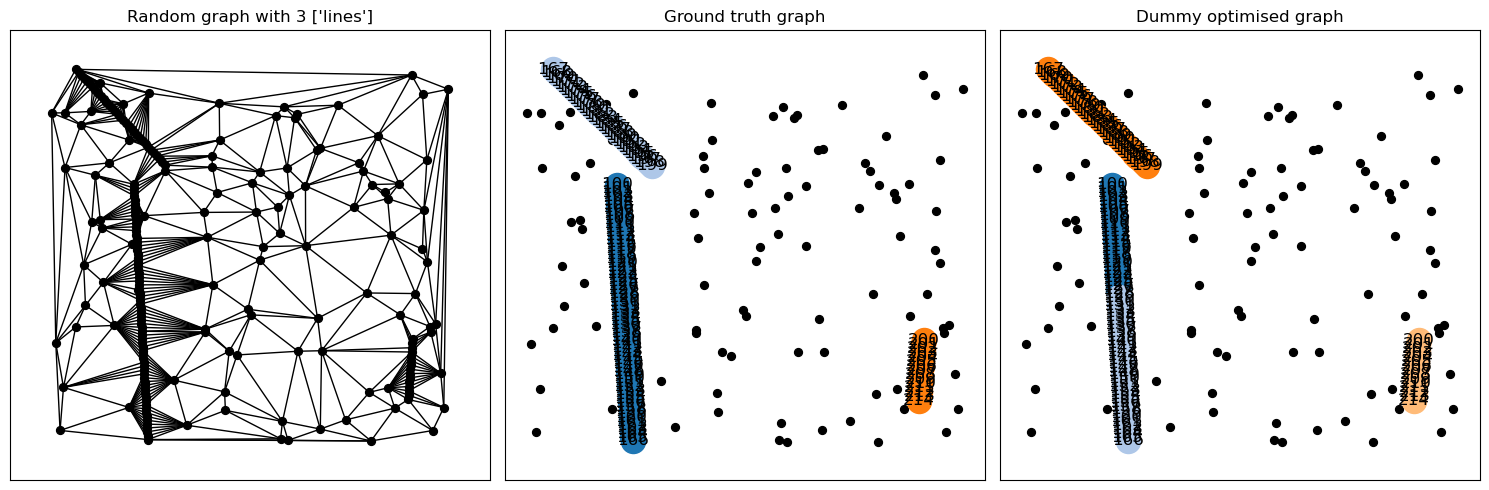

In [7]:
shape = 5
_, axes = plt.subplots(1, 3, figsize=(shape*3, shape*1))

plot_simple_graph(G, title=f"Random graph with {N_MOTIFS} {MOTIFS}", ax=axes[0])
plot_connected_components(true_graph, title=f"Ground truth graph", ax=axes[1])
plot_connected_components(pred_graph, title=f"Dummy optimised graph", ax=axes[2])

plt.tight_layout()
plt.show()

### Create a dummy feature vector for nodes:

In [8]:
for _, node in G.nodes(data=True):
    feature = np.random.random() * 0.5
    if node["label"] > 0:
        feature = 1 - feature
    
    # Create the tensor
    num_repeats = 4
    features = torch.full((num_repeats,), fill_value=feature, dtype=torch.float32)
    node[GraphAttrs.NODE_FEATURES] = features.squeeze()


### Predict the node & edge probs:

In [9]:
from grace.models.datasets import dataset_from_graph

In [10]:
# inf_dataset = dataset_from_graph(G, mode="whole", in_train_mode=False)
sub_dataset = dataset_from_graph(G, mode="sub", in_train_mode=False)
len(sub_dataset)

215

In [11]:
for d, data in enumerate(sub_dataset):
    print (d, data)
    break


0 Data(x=[11, 4], edge_index=[2, 20], edge_attr=[11, 2], y=[11], pos=[11, 2], edge_label=[20])


In [12]:
data.x, data.edge_index

(tensor([[0.1139, 0.1139, 0.1139, 0.1139],
         [0.3080, 0.3080, 0.3080, 0.3080],
         [0.7128, 0.7128, 0.7128, 0.7128],
         [0.6230, 0.6230, 0.6230, 0.6230],
         [0.5891, 0.5891, 0.5891, 0.5891],
         [0.5063, 0.5063, 0.5063, 0.5063],
         [0.0608, 0.0608, 0.0608, 0.0608],
         [0.6665, 0.6665, 0.6665, 0.6665],
         [0.5116, 0.5116, 0.5116, 0.5116],
         [0.5677, 0.5677, 0.5677, 0.5677],
         [0.4403, 0.4403, 0.4403, 0.4403]]),
 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  2,  3,  4,  5,  7,
           8,  9],
         [ 8,  2,  7,  6,  5, 10,  1,  4,  9,  3,  6, 10,  3,  6,  4,  5,  7,  8,
           9, 10]]))

### Get the predictions:

In [13]:
node_softmax_preds = []
edge_softmax_preds = []
node_argmax_preds = []
edge_argmax_preds = []
node_labels = []
edge_labels = []


for data in tqdm(sub_dataset, desc="Predicting for individual subgraphs: "):

    # Predict labels from sub-graph:
    result = pre_trained_gcn.predict(x=data.x, edge_index=data.edge_index)
    node_emb, edge_emb, node_x, edge_x = result
    print (data)
    print ([r.shape for r in result])

    # Process nodes probs into classes predictions:
    node_labels.extend(data.y)
    
    # node_soft = softmax(node_x, dim=1)
    node_soft = node_x.softmax(dim=1)
    node_softmax_preds.extend(node_soft)

    node_arg = node_soft.argmax(dim=1).long()
    node_argmax_preds.extend(node_arg)

    # Process nodes probs into classes predictions:
    edge_labels.extend(data.edge_label)
    
    # edge_soft = softmax(edge_x, dim=1)
    edge_soft = edge_x.softmax(dim=1)
    edge_softmax_preds.extend(edge_soft)

    edge_arg = edge_soft.argmax(dim=1).long()
    edge_argmax_preds.extend(edge_arg)

    # break

# Stack the results:
node_softmax_preds = torch.stack(node_softmax_preds, axis=0)
edge_softmax_preds = torch.stack(edge_softmax_preds, axis=0)
node_argmax_preds = torch.stack(node_argmax_preds, axis=0)
edge_argmax_preds = torch.stack(edge_argmax_preds, axis=0)
node_labels = torch.stack(node_labels, axis=0)
edge_labels = torch.stack(edge_labels, axis=0)

node_softmax_preds.shape, node_argmax_preds.shape, node_labels.shape

Predicting for individual subgraphs: 100%|██████████| 215/215 [00:00<00:00, 2279.40it/s]

Data(x=[11, 4], edge_index=[2, 20], edge_attr=[11, 2], y=[11], pos=[11, 2], edge_label=[20])
[torch.Size([11, 4]), torch.Size([20, 8]), torch.Size([11, 2]), torch.Size([20, 2])]
Data(x=[7, 4], edge_index=[2, 12], edge_attr=[7, 2], y=[7], pos=[7, 2], edge_label=[12])
[torch.Size([7, 4]), torch.Size([12, 8]), torch.Size([7, 2]), torch.Size([12, 2])]
Data(x=[6, 4], edge_index=[2, 10], edge_attr=[6, 2], y=[6], pos=[6, 2], edge_label=[10])
[torch.Size([6, 4]), torch.Size([10, 8]), torch.Size([6, 2]), torch.Size([10, 2])]
Data(x=[6, 4], edge_index=[2, 10], edge_attr=[6, 2], y=[6], pos=[6, 2], edge_label=[10])
[torch.Size([6, 4]), torch.Size([10, 8]), torch.Size([6, 2]), torch.Size([10, 2])]
Data(x=[7, 4], edge_index=[2, 12], edge_attr=[7, 2], y=[7], pos=[7, 2], edge_label=[12])
[torch.Size([7, 4]), torch.Size([12, 8]), torch.Size([7, 2]), torch.Size([12, 2])]
Data(x=[4, 4], edge_index=[2, 6], edge_attr=[4, 2], y=[4], pos=[4, 2], edge_label=[6])
[torch.Size([4, 4]), torch.Size([6, 8]), torch.

## Evaluation:
### Simple metrics first:

In [14]:
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    average_precision_score,
    PrecisionRecallDisplay,
)


In [15]:
node_acc = accuracy_score(y_pred=node_argmax_preds, y_true=node_labels)
edge_acc = accuracy_score(y_pred=edge_argmax_preds, y_true=edge_labels)
node_acc, edge_acc


(0.034482758620689655, 0.884310618066561)

### Display confusion matrices:

In [16]:
# node_conf_mat = confusion_matrix(y_pred=node_argmax_preds, y_true=node_labels)
# edge_conf_mat = confusion_matrix(y_pred=edge_argmax_preds, y_true=edge_labels)
# node_conf_mat, edge_conf_mat


(array([[ 51, 568],
        [860,   0]]),
 array([[1816,  260],
        [  32,  416]]))

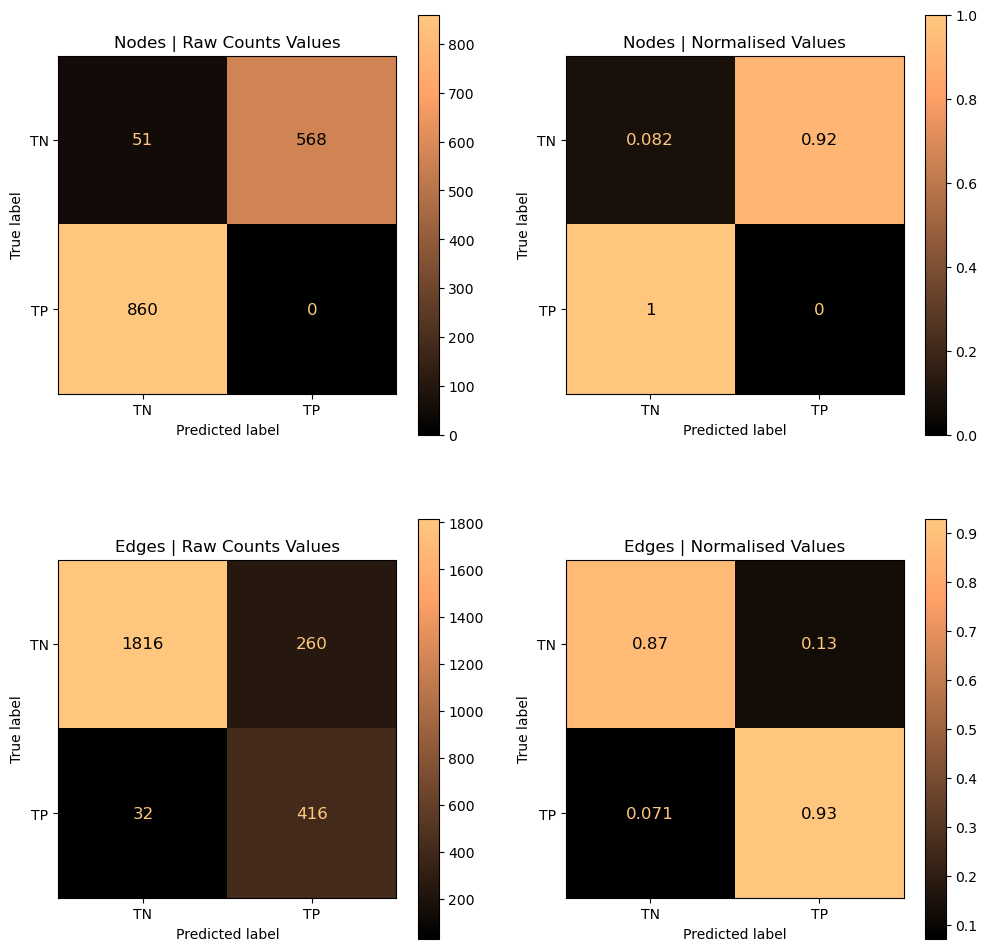

In [58]:
figsize = (12, 12)
colormap = "copper"
confusion_matrix_plotting_data = [
    [node_argmax_preds, node_labels, "nodes"], 
    [edge_argmax_preds, edge_labels, "edges"],
]

_, axs = plt.subplots(2, 2, figsize=figsize)

for d, matrix_data in enumerate(confusion_matrix_plotting_data):
    for n, nrm in enumerate([None, "true"]):
        ConfusionMatrixDisplay.from_predictions(
            y_pred=matrix_data[0],
            y_true=matrix_data[1],
            normalize=nrm,
            ax=axs[d, n],
            cmap=colormap,
            display_labels=["TN", "TP"],
            text_kw={"fontsize": "large"},
        )

        flag = "Raw Counts" if nrm is None else "Normalised"
        text = f"{matrix_data[2].capitalize()} | {flag} Values"
        axs[d, n].set_title(text)

plt.show()


### More complex metrics:
#### Receiver-operator curve:

In [59]:
n_pred, e_pred = node_softmax_preds[:, 1], edge_softmax_preds[:, 1]
n_pred.shape, e_pred.shape

(torch.Size([1479]), torch.Size([2524]))

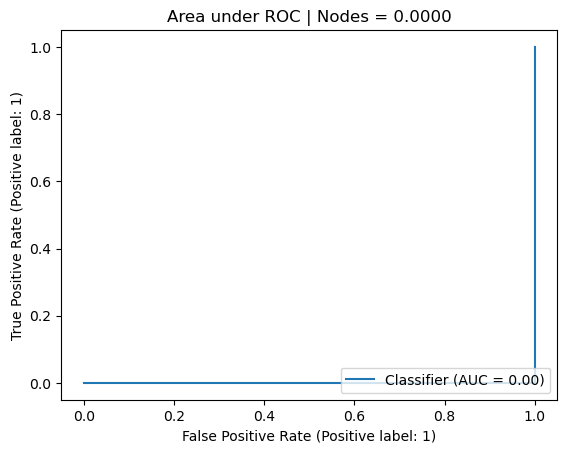

In [33]:
# rcd_nodes = RocCurveDisplay.from_predictions(y_true=node_labels, y_pred=node_softmax_preds[:, 1])
# roc_score_nodes = roc_auc_score(y_true=node_labels, y_score=node_softmax_preds[:, 1])
# plt.title(f"Area under ROC | Nodes = {roc_score_nodes:.4f}")
# # plt.legend("lower right")
# plt.show()

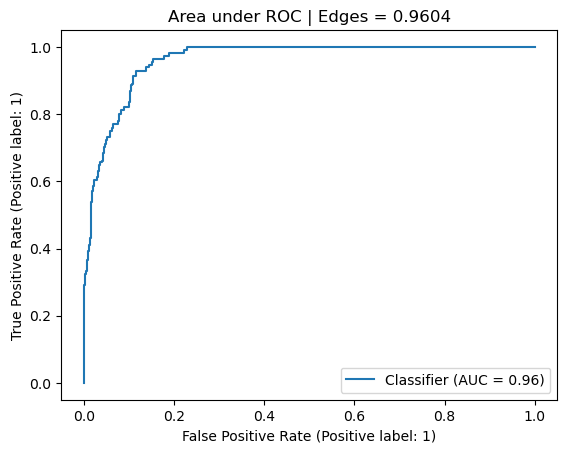

In [34]:
# rcd_edges = RocCurveDisplay.from_predictions(y_true=edge_labels, y_pred=edge_softmax_preds[:, 1])
# roc_score_edges = roc_auc_score(y_true=edge_labels, y_score=edge_softmax_preds[:, 1])
# plt.title(f"Area under ROC | Edges = {roc_score_edges:.4f}")
# # plt.legend("lower right")
# plt.show()

##### Pool these:

### More complex metrics:
#### Precision-recall curve:

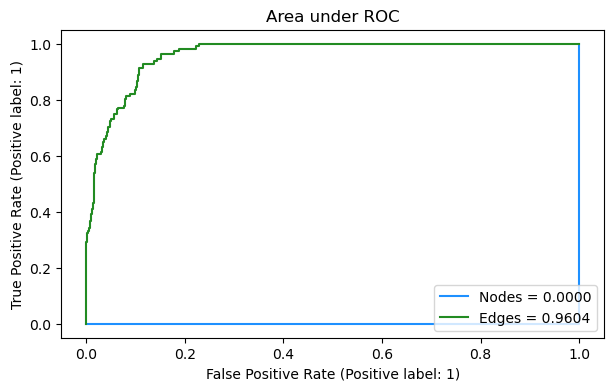

In [52]:
_, ax = plt.subplots(figsize=(7, 4))

roc_score_nodes = roc_auc_score(y_true=node_labels, y_score=n_pred)
rcd_nodes = RocCurveDisplay.from_predictions(
    y_true=node_labels, y_pred=n_pred, color="dodgerblue", 
    label=f"Nodes = {roc_score_nodes:.4f}", ax=ax)

roc_score_edges = roc_auc_score(y_true=edge_labels, y_score=e_pred)
rcd_edges = RocCurveDisplay.from_predictions(
    y_true=edge_labels, y_pred=e_pred, color="forestgreen",
    label=f"Edges = {roc_score_edges:.4f}", ax=ax)

plt.title(f"Area under ROC")
plt.show()

In [ ]:
_, ax = plt.subplots(figsize=(7, 4))

prc_score_nodes = average_precision_score(y_true=node_labels, y_score=n_pred)
prc_nodes = PrecisionRecallDisplay.from_predictions(
    y_true=node_labels, y_pred=n_pred, color="dodgerblue", 
    label=f"Nodes = {prc_score_nodes:.4f}", ax=ax)

prc_score_edges = average_precision_score(y_true=edge_labels, y_score=e_pred)
prc_edges = PrecisionRecallDisplay.from_predictions(
    y_true=edge_labels, y_pred=e_pred, color="forestgreen",
    label=f"Edges = {prc_score_edges:.4f}", ax=ax)

plt.title(f"Average Precision (AUC) Score")
plt.show()

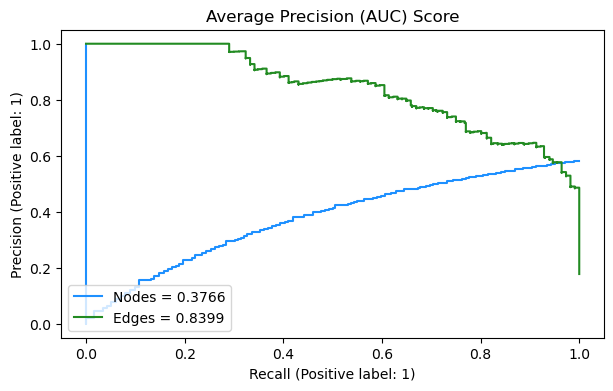

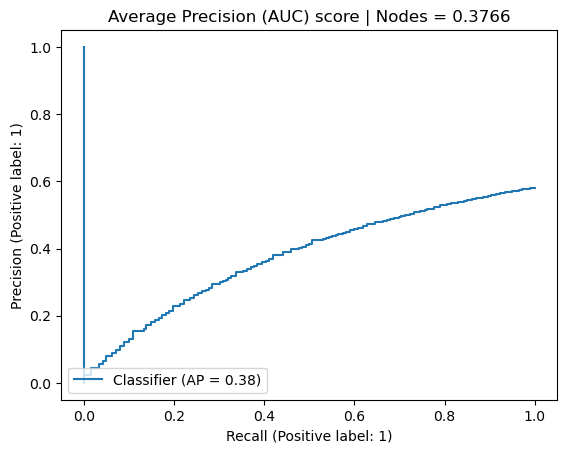

In [35]:
prc_nodes = PrecisionRecallDisplay.from_predictions(y_true=node_labels, y_pred=node_softmax_preds[:, 1])
prc_score_nodes = average_precision_score(y_true=node_labels, y_score=node_softmax_preds[:, 1])
plt.title(f"Average Precision (AUC) score | Nodes = {prc_score_nodes:.4f}")
# plt.legend("upper right")
plt.show()

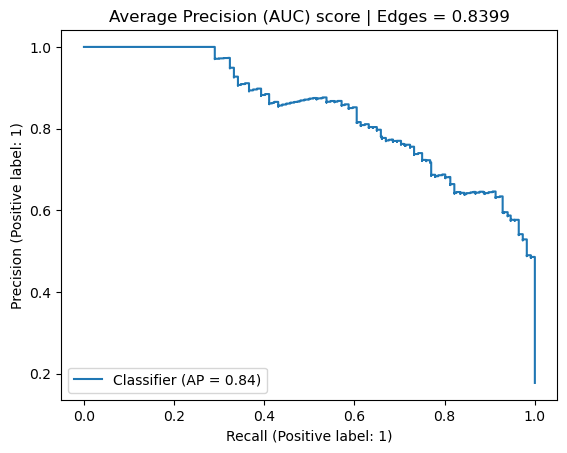

In [36]:
prc_edges = PrecisionRecallDisplay.from_predictions(y_true=edge_labels, y_pred=edge_softmax_preds[:, 1])
prc_score_edges = average_precision_score(y_true=edge_labels, y_score=edge_softmax_preds[:, 1])
plt.title(f"Average Precision (AUC) score | Edges = {prc_score_edges:.4f}")
# plt.legend("upper right")
plt.show()

### Format the plot:

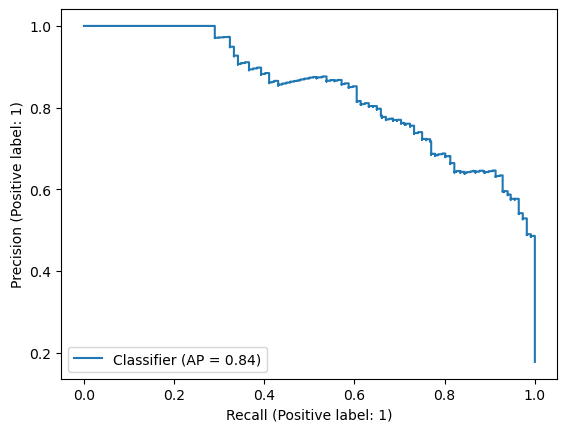

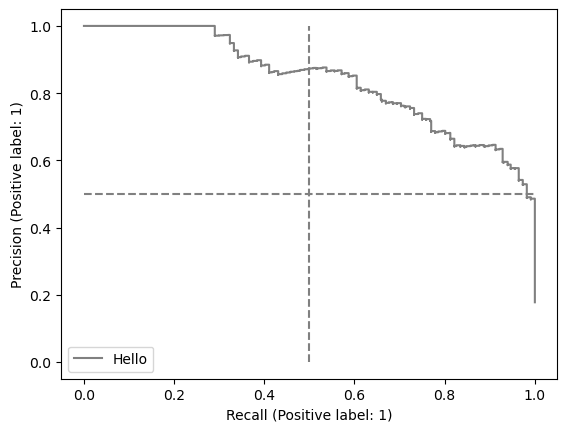

In [47]:
prc_edges = PrecisionRecallDisplay.from_predictions(y_true=edge_labels, y_pred=edge_softmax_preds[:, 1])
prc_edges.plot(color='grey', label="Hello")
# plt.plot([0, 1], [0, 1], color='grey', ls='dashed')
plt.plot([[0, 0.5], [1, 0.5]], [[0.5, 0], [0.5, 1]], color='grey', ls='dashed')
plt.show()